# Tucson basin #

ADWR Regional Groundwater Flow Model of the Tucson Active Management Area, AZ <br>
See Modeling Report No. 24 (Mason & Hipke, 2013) for documentation and context

## Import Python packages ##

In [73]:
import os
import numpy as np
import numpy.ma as ma
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.colors as colors



In [72]:
#Custom functions
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


## Import ADWR model ###

In [2]:
modelname = 'tuc4010'             #name of .nam file

mf = flopy.modflow.Modflow.load(modelname+'.nam', version='mfnwt', exe_name='MODFLOW-NWT.exe', 
                                load_only=['bas6','rch','evt','wel','chd','upw','oc'], #only load relevant packages
                                verbose=False, check=True)

Text(0, 0.5, 'y [m]')

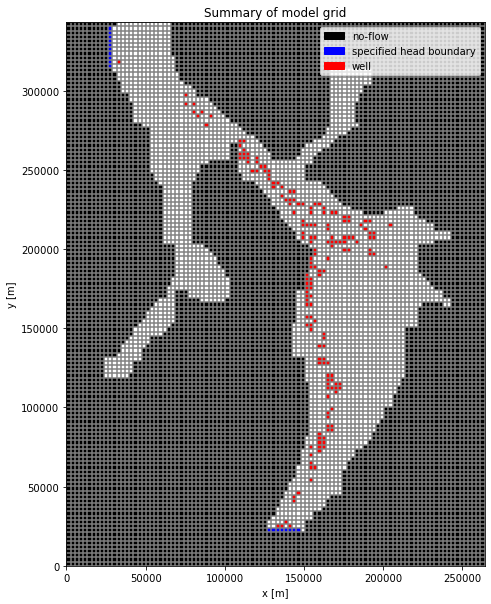

In [3]:
#Plot model boundary conditions summary:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Summary of model grid')                          #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
bc = m.plot_ibound()                                        #plot boundary conditions
w = m.plot_bc("WEL", color='red')                           #plot wells
w = m.plot_bc("CHD", color='blue')                           #plot specified head boundaries

#Format and legend
plt.legend(handles=[matplotlib.patches.Patch(color='black', label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue', label='specified head boundary'),
                    #matplotlib.patches.Patch(color='skyblue', label='stream'),
                    #matplotlib.patches.Patch(color='green', label='highest ET zone'),
                    matplotlib.patches.Patch(color='red', label='well')])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

Text(0.5, 1.0, 'west-east cross-section in row50')

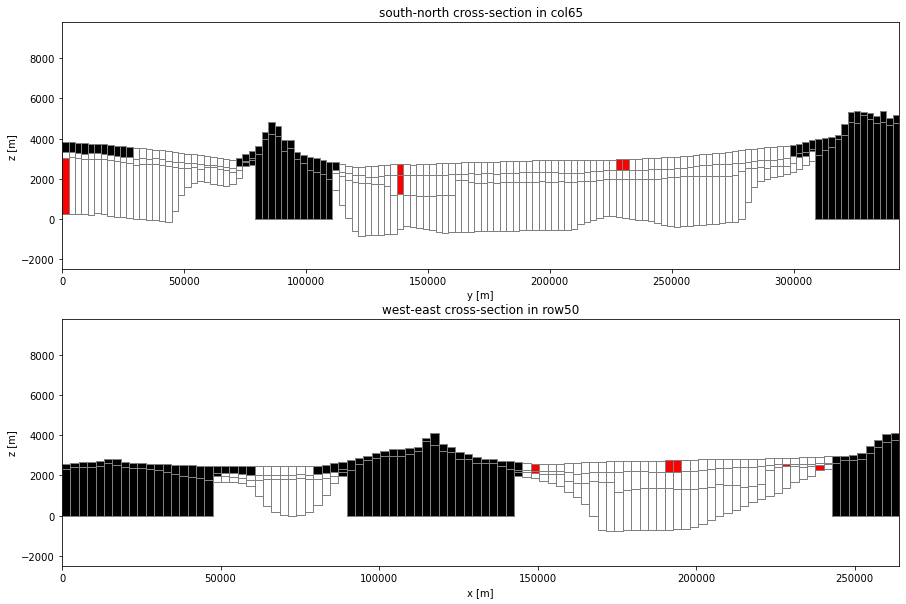

In [4]:
#Plot cross-section view of model:

#South-North:
col = 65
f,ax = plt.subplots(2,1, figsize=(15,10))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': col})   #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
w = xsec.plot_bc("WEL", color='red')                                         #plot wells
w = xsec.plot_bc("CHD", color='blue')                           #plot specified head boundaries
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section in col'+str(col))

#East-West:
row = 50
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': row})    #plot cross-ection along stream row
bc = xsec.plot_ibound()                                                         #plot boundary conditions
w = xsec.plot_bc("WEL", color='red')                                            #plot wells
w = xsec.plot_bc("CHD", color='blue')                           #plot specified head boundaries

g  = xsec.plot_grid()                                                           #plot grid
#st = ax[1].plot(str_cols*delc, str_top, c='sienna')                             #plot streambed top
#sb = ax[1].plot(str_cols*delc, str_bot, c='goldenrod')                          #plot streambed top
#sg = ax[1].plot(str_cols*delc, stage_elev, c='dodgerblue')                      #plot streambed top

ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section in row'+str(row))

## Get model info, rewrite new input files for MODFLOW-2005 ##

In [19]:
#Get package objects from original model
dis = mf.get_package('DIS')
bas = mf.get_package('BAS6')
oc = mf.get_package('OC')
chd = mf.get_package('CHD')
upw = mf.get_package('UPW')
rch = mf.get_package('RCH')
evt = mf.get_package('EVT')
wel = mf.get_package('WEL')

In [21]:
#Create model object and new input objects (with some modifications):
modelname = 'tucson'
mf2 = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
dis = flopy.modflow.ModflowDis(mf2, nlay=dis.nlay, nrow=dis.nrow, ncol=dis.ncol, nper=dis.nper, delr=dis.delr, delc=dis.delc, 
                               laycbd=dis.laycbd, lenuni=dis.lenuni, nstp=dis.nstp, perlen=dis.perlen, 
                               start_datetime=dis.start_datetime, steady=dis.steady, top=dis.top, botm=dis.botm, tsmult=dis.tsmult)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf2, ibound=bas.ibound, strt=bas.strt)           #BAS (Basic): assigns head boundaries
oc = flopy.modflow.ModflowOc(mf2, stress_period_data=oc.stress_period_data, compact=True) #OC (Output Control): Decides what outputs to save
chd = flopy.modflow.ModflowChd(mf2,stress_period_data=chd.stress_period_data)
#lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        #ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
lpf = flopy.modflow.ModflowLpf(mf, laytyp=upw.laytyp, chani=upw.chani, hk=upw.hk, hani=upw.hani, vka=upw.vka, 
        ss=upw.ss, sy=upw.sy, storagecoefficient=False, ipakcb=upw.ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
rch = flopy.modflow.mfrch.ModflowRch(mf2, rech=rch.rech)                       #RCH (Recharge)
evt = flopy.modflow.mfevt.ModflowEvt(mf2, surf=evt.surf, evtr=evt.evtr, exdp=evt.exdp, ipakcb=53)  #EVT (Evapotranspiration)
wel = flopy.modflow.mfwel.ModflowWel(mf2, stress_period_data=wel.stress_period_data)     #WEL (Well)  

In [22]:
#Write MODFLOW input files:
mf2.write_input()

## Run new model ##

In [23]:
#Run MODFLOW:
success, buff = mf2.run_model(silent=True)                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tucson.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/01/11 14:42:08

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     2    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     3    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     4    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     5    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     6    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     7    Ground-Water Flow Eq

## Get outputs ##

In [32]:
#Get MODFLOW outputs:
hds = bf.HeadFile('tucson.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

In [33]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

                WELLS_IN' 	 31771863000.0
                   ET_IN' 	        0.0
             RECHARGE_IN' 	 576598800000.0
                TOTAL_IN' 	 608370600000.0
               WELLS_OUT' 	 -873984160000.0
                  ET_OUT' 	 -41035907000.0
            RECHARGE_OUT' 	       -0.0
               TOTAL_OUT' 	 -915020050000.0
                  IN-OUT' 	 -306650000000.0
     PERCENT_DISCREPANCY' 	     -40.26

timesteps: [366.0, 2191.9998, 4018.0037, 5843.9966, 7670.9907, 9496.998, 11323.014, 13149.029, 15706.049, 17898.03, 20453.982, 21914.959, 23741.936, 25932.896]
stress periods: [(0, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (11, 19), (11, 20), (11, 21), (11, 22), (11, 23), (11, 24), (11, 25), (11, 26), (11, 27), (11, 28), (11, 29), (11, 30), (11, 31), (11, 32), (11, 33), (11, 34), (11, 35), (11, 36), (11, 37), (11, 

In [47]:
#Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

lay = 0                     #layer piezometer is in
row = 50                    #row piezometer is in
col = 70                    #column piezometer is in
h = head[lay,row,col]       #head at piezometer location

piezo = np.full((dis.nlay,dis.nrow,dis.ncol), np.nan)  #create array of null values to be able to map piezometer
piezo[lay,row,col] = 1                     #mark the piezometer location with a 1

vmin = head_mx.min()                      #find the lowest head (excluding no-flow cells)
vmax = head_mx.max()                      #find the highest head (excluding no-flow cells)

text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places, add a tab before the last item)
print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values

text = 'Min. head: \t\t\t\t{} m \nMax. head: \t\t\t\t{:.3f} m'
print(text.format(vmin,vmax))

Head at layer 0, row 50, col 70: 	2408.000 m
Min. head: 				1550.0 m 
Max. head: 				3070.000 m


Text(0, 0.5, 'y [m]')

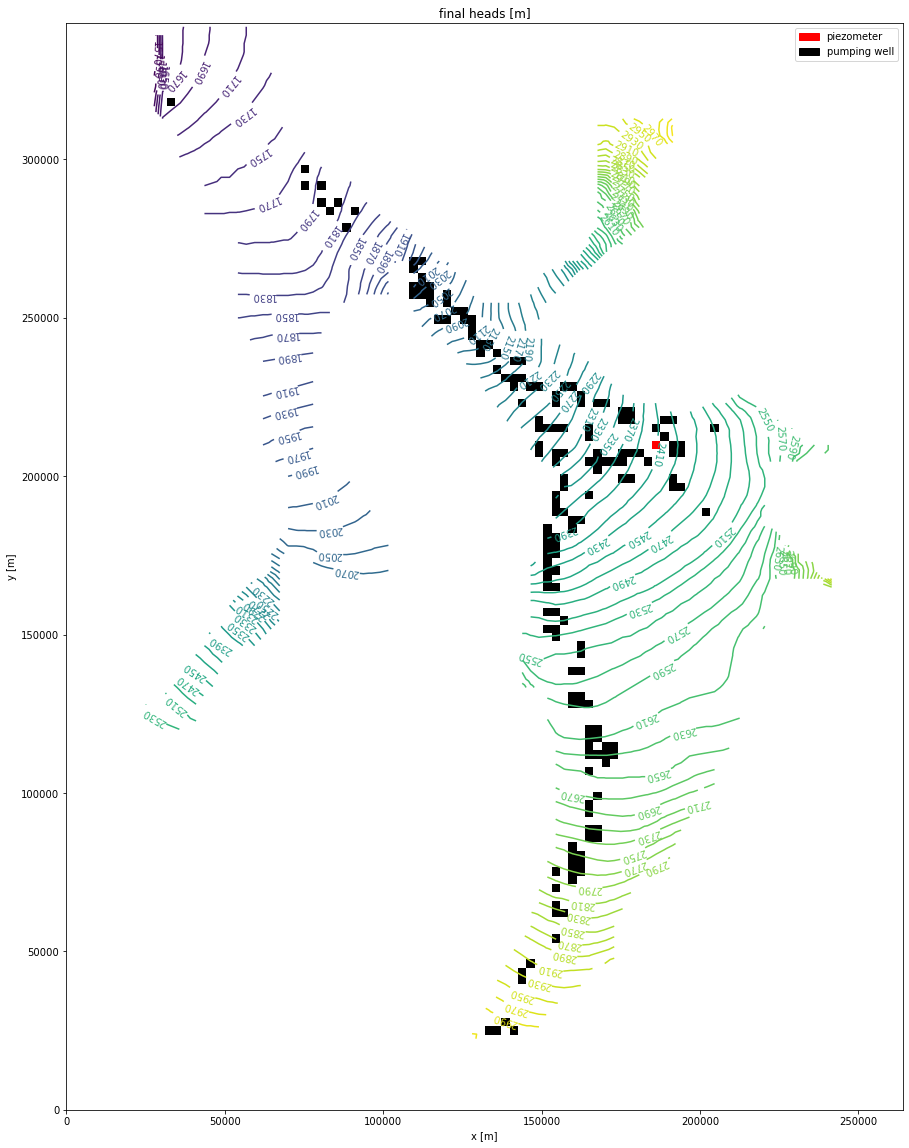

In [49]:
#Plot the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(20,20))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf2)           #create flopy map object
#h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 20)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels) #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
p = maps.plot_array(piezo, cmap='hsv')           #plot piezo
w = maps.plot_bc("WEL", color='k')            #plot stream

#Add legend and axis labels
plt.legend(handles=[matplotlib.patches.Patch(color='red',label='piezometer'),
                    matplotlib.patches.Patch(color='k',  label='pumping well')]) #add legend manually
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')


In [115]:
lpf


    MODFLOW Layer Property Flow Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int
        A flag that is used to determine if cell-by-cell budget data should be
        saved. If ipakcb is non-zero cell-by-cell budget data will be saved.
        (default is 0)
    hdry : float
        Is the head that is assigned to cells that are converted to dry during
        a simulation. Although this value plays no role in the model
        calculations, it is useful as an indicator when looking at the
        resulting heads that are output from the model. HDRY is thus similar
        to HNOFLO in the Basic Package, which is the value assigned to cells
        that are no-flow cells at the start of a model simulation.
        (default is -1.e30).
    laytyp : int or array of ints (nlay)
        Layer type, contains a flag for each layer that spe

In [102]:
#Set custom colormaps
cmap = plt.get_cmap('terrain')
major_contours = truncate_colormap(cmap, 0.8, 0.8)
minor_contours = truncate_colormap(cmap, 0.6, 0.6)

<a list of 46 text.Text objects>

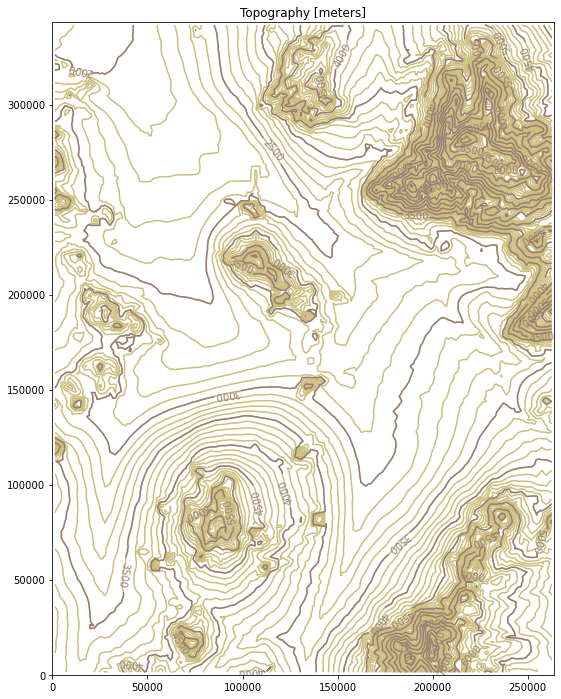

In [110]:
#Plot land surface topography
f,ax = plt.subplots(1,1, figsize=(12,12))         #create figure and axis objects
ax.set_title('Topography [meters]')
maps = flopy.plot.PlotMapView(model=mf2)           #create flopy map object
#h = maps.plot_array(dis.top.array,  cmap='binary')  #plot heads as grayscale map
levels = np.arange(1800, 9800, 100)                       #set contour range and interval
c = maps.contour_array(dis.top.array, levels=levels, cmap=minor_contours) #plot head contours
levels = np.arange(1500,10000, 500)                       #set contour range and interval
c = maps.contour_array(dis.top.array, levels=levels, cmap=major_contours) #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  

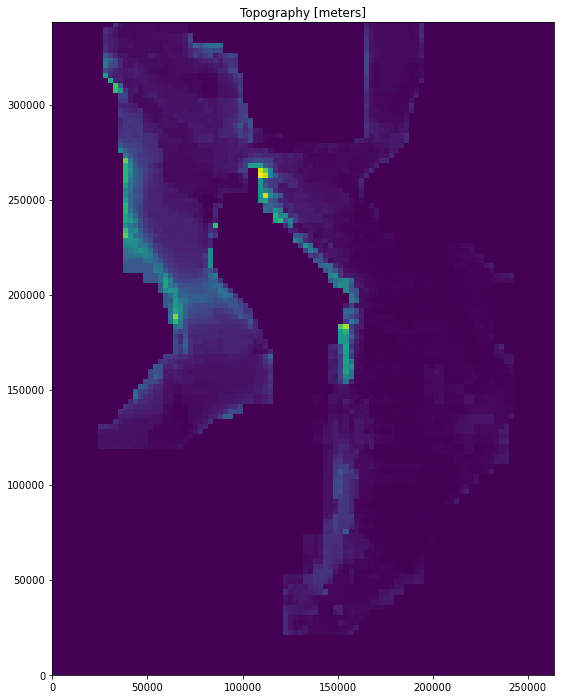

In [119]:
#Plot hydraulic conductivity along rows
f,ax = plt.subplots(1,1, figsize=(12,12))         #create figure and axis objects
ax.set_title('Topography [meters]')
maps = flopy.plot.PlotMapView(model=mf2)           #create flopy map object
h = maps.plot_array(lpf.hk.array[2,:,:],  cmap='viridis')  #plot heads as grayscale map
